### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Eastern_Himalayas/Cleaned_Himalayas_CLEANED"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]12:52:8 Generating bigrams
[INFO]12:52:8 Generating word bigrams
[INFO]12:52:10 Generated word bigrams
[INFO]12:52:11 Beginning lemmatization
[INFO]12:52:21 Ending lemmatization
[INFO]12:52:36 Issued perplexity: -9.734676046879516
[INFO]12:52:36 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.073*"forest" + 0.046*"land" + 0.023*"landscape" + 0.023*"area" + 0.021*"wetland" + 0.016*"cover" + 0.014*"change" + 0.011*"conservation" + 0.010*"population" + 0.010*"habitat"'),
 (1,
  '0.009*"region" + 0.008*"distribution" + 0.007*"sample" + 0.007*"group" + 0.007*"include" + 0.007*"china" + 0.006*"range" + 0.006*"result" + 0.006*"pattern" + 0.006*"suggest"'),
 (2,
  '0.020*"ice" + 0.020*"branch" + 0.018*"tibetan" + 0.017*"upland" + 0.017*"indus" + 0.015*"wood" + 0.014*"trade" + 0.012*"var" + 0.012*"domesticate" + 0.011*"quite"'),
 (3,
  '0.117*"lake" + 0.049*"gis" + 0.035*"stream" + 0.029*"remote_sense" + 0.027*"fish" + 0.024*"freshwater" + 0.015*"month" + 0.013*"salinity" + 0.010*"september" + 0.009*"brahmaputra"'),
 (4,
  '0.026*"crop" + 0.015*"rice" + 0.014*"system" + 0.014*"production" + 0.014*"increase" + 0.012*"yield" + 0.012*"high" + 0.010*"ratio" + 0.010*"nitrogen" + 0.010*"concentration"'),
 (5,
  '0.017*"model" + 0.016*"increase" + 0.015*"change" + 0.013*"temperat

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(4,
  [('area', 0.03192061397076795),
   ('datum', 0.02659236447181894),
   ('land', 0.021801828225057437),
   ('cover', 0.021166348927017648),
   ('model', 0.020335337537273304),
   ('base', 0.01588698245099477),
   ('map', 0.014176076648579948),
   ('analysis', 0.013345065258835607),
   ('distribution', 0.012562936892017403),
   ('estimate', 0.012416287823238989)]),
 (11,
  [('soil', 0.052414605418138985),
   ('crop', 0.021683263732733698),
   ('land', 0.020987257736374346),
   ('high', 0.019274012206874396),
   ('increase', 0.0184709283649213),
   ('xa', 0.01643644929864011),
   ('erosion', 0.015526287611093264),
   ('system', 0.015044437305921405),
   ('rate', 0.013866581004390192),
   ('production', 0.012046257629296498)]),
 (1,
  [('population', 0.060259802742362284),
   ('genetic', 0.037466923261967766),
   ('diversity', 0.02838585518402694),
   ('variation', 0.01677892711089728),
   ('analysis', 0.016357950445032476),
   ('reveal', 0.016297810921337502),
   ('level', 0.0129299

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5015588726040042


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

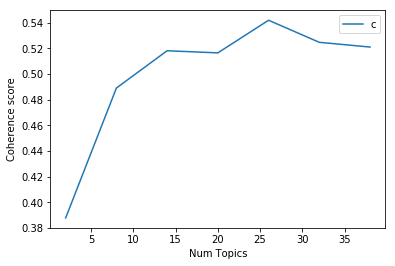

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)
print(model_topics)

[(11, [('soil', 0.052414605418138985), ('crop', 0.021683263732733698), ('land', 0.020987257736374346), ('high', 0.019274012206874396), ('increase', 0.0184709283649213), ('xa', 0.01643644929864011), ('erosion', 0.015526287611093264), ('system', 0.015044437305921405), ('rate', 0.013866581004390192), ('production', 0.012046257629296498)]), (2, [('water', 0.05715131773763696), ('river', 0.03156647912348238), ('basin', 0.021912940479715724), ('lake', 0.019070180633698548), ('result', 0.009653538643766656), ('major', 0.00882440035534498), ('concentration', 0.00882440035534498), ('wetland', 0.008646727864968907), ('sediment', 0.008113710393840687), ('total', 0.007995262066923305)]), (8, [('conservation', 0.047033321570802034), ('habitat', 0.02676816050814135), ('local', 0.019811463426929476), ('biodiversity', 0.019408176639612845), ('nepal', 0.015576952160104855), ('human', 0.012653122952059283), ('community', 0.012401068709986389), ('protect', 0.01109038665120734), ('people', 0.0106870998638

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.013*"zone" + 0.010*"time" + 0.010*"east" + 0.010*"plateau" + '
  '0.009*"mountain" + 0.009*"part" + 0.009*"western" + 0.009*"eastern" + '
  '0.009*"large" + 0.008*"south" + 0.008*"process" + 0.007*"west" + 0.007*"xa" '
  '+ 0.007*"middle" + 0.006*"rock" + 0.006*"present" + 0.006*"central" + '
  '0.006*"formation" + 0.006*"northern" + 0.006*"suggest" + 0.006*"tectonic" + '
  '0.005*"influence" + 0.005*"basin" + 0.005*"north" + 0.005*"continental" + '
  '0.005*"tibetan_plateau" + 0.005*"mass" + 0.005*"associate" + '
  '0.005*"feature" + 0.004*"boundary" + 0.004*"model" + 0.004*"uplift" + '
  '0.004*"geological" + 0.004*"stage" + 0.004*"upper" + 0.004*"amount" + '
  '0.004*"evolution" + 0.004*"occur" + 0.004*"activity" + 0.004*"mechanism"'),
 (1,
  '0.060*"population" + 0.037*"genetic" + 0.028*"diversity" + '
  '0.017*"variation" + 0.016*"analysis" + 0.016*"reveal" + 0.013*"level" + '
  '0.013*"show" + 0.011*"group" + 0.010*"structure" + 0.009*"accession" + '
  '0.008*"number" +

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2832,"conservation, habitat, local, biodiversity, ne...",[Himalayan high-altitude wetlands (HAWs) are s...
1,1,3.0,0.2621,"development, resource, research, environmental...",[The Kangchenjunga Landscape (KL) in the Easte...
2,2,0.0,0.2745,"zone, time, east, plateau, mountain, part, wes...",[Large tropical volcanic eruptions can cause s...
3,3,4.0,0.1980,"area, datum, land, cover, model, base, map, an...",[Climate variability is the most influential d...
4,4,11.0,0.6431,"soil, crop, land, high, increase, xa, erosion,...",[Poor soil quality and low fertility are major...
5,5,3.0,0.2801,"development, resource, research, environmental...","[The Kangchenjunga landscape, a transboundary ..."
6,6,1.0,0.3167,"population, genetic, diversity, variation, ana...",[The epiphytic lichen Lobaria pindarensis is a...
7,7,7.0,0.2845,"forest, tree, vegetation, site, elevation, hig...",[The lowland areas of the Himalayan region are...
8,8,11.0,0.4629,"soil, crop, land, high, increase, xa, erosion,...",[Large-scale land degradation occurs in the fo...
9,9,4.0,0.2360,"area, datum, land, cover, model, base, map, an...",[Cumulative environmental impact assessment (C...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,8.0,"conservation, habitat, local, biodiversity, ne...",186.0,0.0864
1,3.0,"development, resource, research, environmental...",159.0,0.0738
2,0.0,"zone, time, east, plateau, mountain, part, wes...",145.0,0.0673
3,4.0,"area, datum, land, cover, model, base, map, an...",253.0,0.1175
4,11.0,"soil, crop, land, high, increase, xa, erosion,...",190.0,0.0882
5,3.0,"development, resource, research, environmental...",83.0,0.0385
6,1.0,"population, genetic, diversity, variation, ana...",183.0,0.0850
7,7.0,"forest, tree, vegetation, site, elevation, hig...",211.0,0.0980
8,11.0,"soil, crop, land, high, increase, xa, erosion,...",189.0,0.0877
9,4.0,"area, datum, land, cover, model, base, map, an...",200.0,0.0929


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      24.028385        1       1 -0.234975 -0.066022
5      21.424107        1       2 -0.265006 -0.030360
8      20.026932        1       3 -0.225601 -0.180409
4       7.423475        1       4 -0.093974  0.008268
6       7.056049        1       5 -0.078757  0.162432
0       5.989110        1       6 -0.019909  0.063276
10      5.482545        1       7 -0.030801  0.270818
7       3.060722        1       8  0.160160 -0.112736
11      2.296456        1       9  0.195699 -0.115499
9       1.883651        1      10  0.183620  0.022926
3       0.699433        1      11  0.206839 -0.009594
2       0.629136        1      12  0.202704 -0.013099, topic_info=      Category         Freq                  Term        Total  loglift  \
258    Default  1748.000000                forest  1748.000000  30.0000   
12063  Default   977.000000                 water   977.000000  29.0000   
16371  Default   845.000000                  soil   845.000000  28.0000   
14892  Default   764.000000                  tree   764.000000  27.0000   
11726  Default   921.000000                  land   921.000000  26.0000   
3310   Default  1006.000000            population  1006.000000  25.0000   
4943   Default  1002.000000                 plant  1002.000000  24.0000   
254    Default   424.000000                 river   424.000000  23.0000   
11431  Default   446.000000                 basin   446.000000  22.0000   
2408   Default   578.000000               genetic   578.000000  21.0000   
9167   Default   885.000000                  area   885.000000  20.0000   
12051  Default  1111.000000                change  1111.000000  19.0000   
2682   Default   794.000000                  high   794.000000  18.0000   
5707   Default   455.000000                  crop   455.000000  17.0000   
8968   Default   672.000000             diversity   672.000000  16.0000   
8775   Default   966.000000                 model   966.000000  15.0000   
13581  Default  1254.000000              increase  1254.000000  14.0000   
16515  Default   680.000000           temperature   680.000000  13.0000   
16396  Default   382.000000             landscape   382.000000  12.0000   
12715  Default   194.000000                  lake   194.000000  11.0000   
12954  Default   612.000000         precipitation   612.000000  10.0000   
17817  Default   832.000000                system   832.000000   9.0000   
7291   Default   561.000000             community   561.000000   8.0000   
13101  Default   304.000000               wetland   304.000000   7.0000   
16576  Default   294.000000              richness   294.000000   6.0000   
15981  Default   648.000000               climate   648.000000   5.0000   
18072  Default   539.000000             variation   539.000000   4.0000   
11122  Default   233.000000               biomass   233.000000   3.0000   
3603   Default   344.000000               surface   344.000000   2.0000   
3882   Default   669.000000              resource   669.000000   1.0000   
...        ...          ...                   ...          ...      ...   
714    Topic12    25.594633                upland    26.608704   5.0297   
3342   Topic12    24.711340                 indus    25.725302   5.0284   
1925   Topic12    23.012350                  wood    24.026297   5.0255   
3507   Topic12    20.920410                 trade    21.934357   5.0212   
15819  Topic12    17.729267                   var    18.743248   5.0130   
11068  Topic12    17.231590           domesticate    18.245556   5.0114   
5882   Topic12    15.926577                 quite    16.940563   5.0069   
12773  Topic12    14.171240                 price    15.185193   4.9995   
10880  Topic12    14.148556                 terai    15.162533   4.9994   
7238   Topic12    13.355649                 brown    14.369618   4.9954   
6250   Topic12    12.896482        recommendation  

In [38]:
topics = optimal_model.show_topics(num_topics = -1, formatted=False)

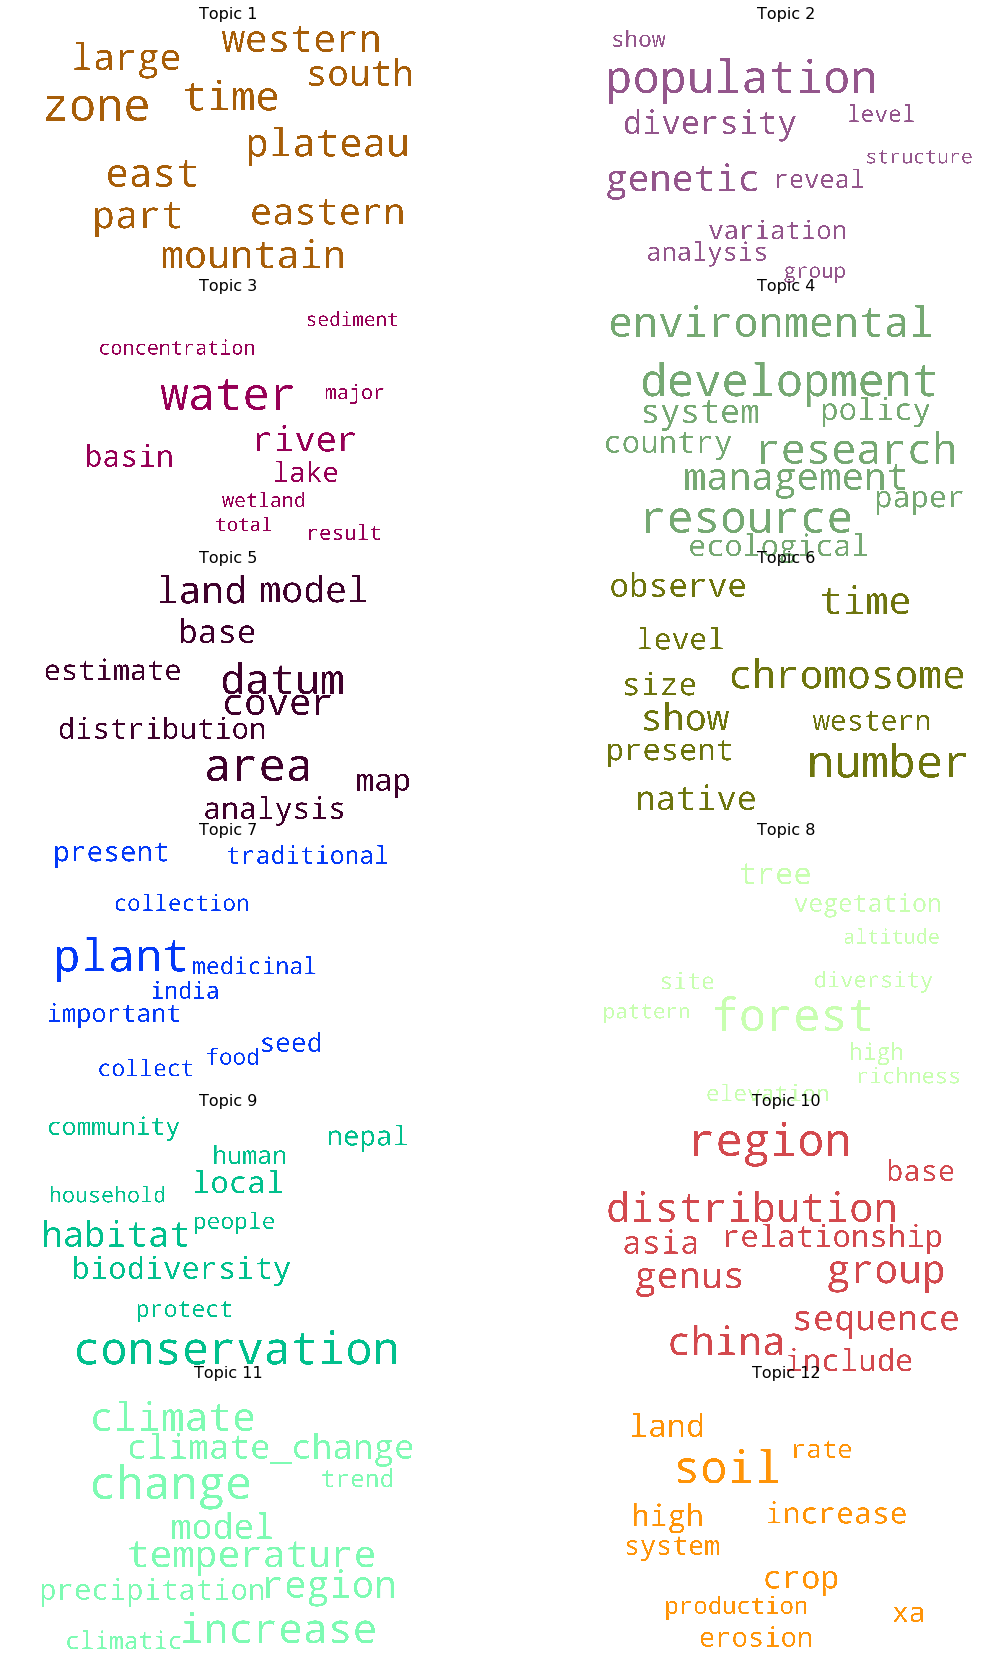

In [39]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab8',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(6, 2, figsize = (20, 30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

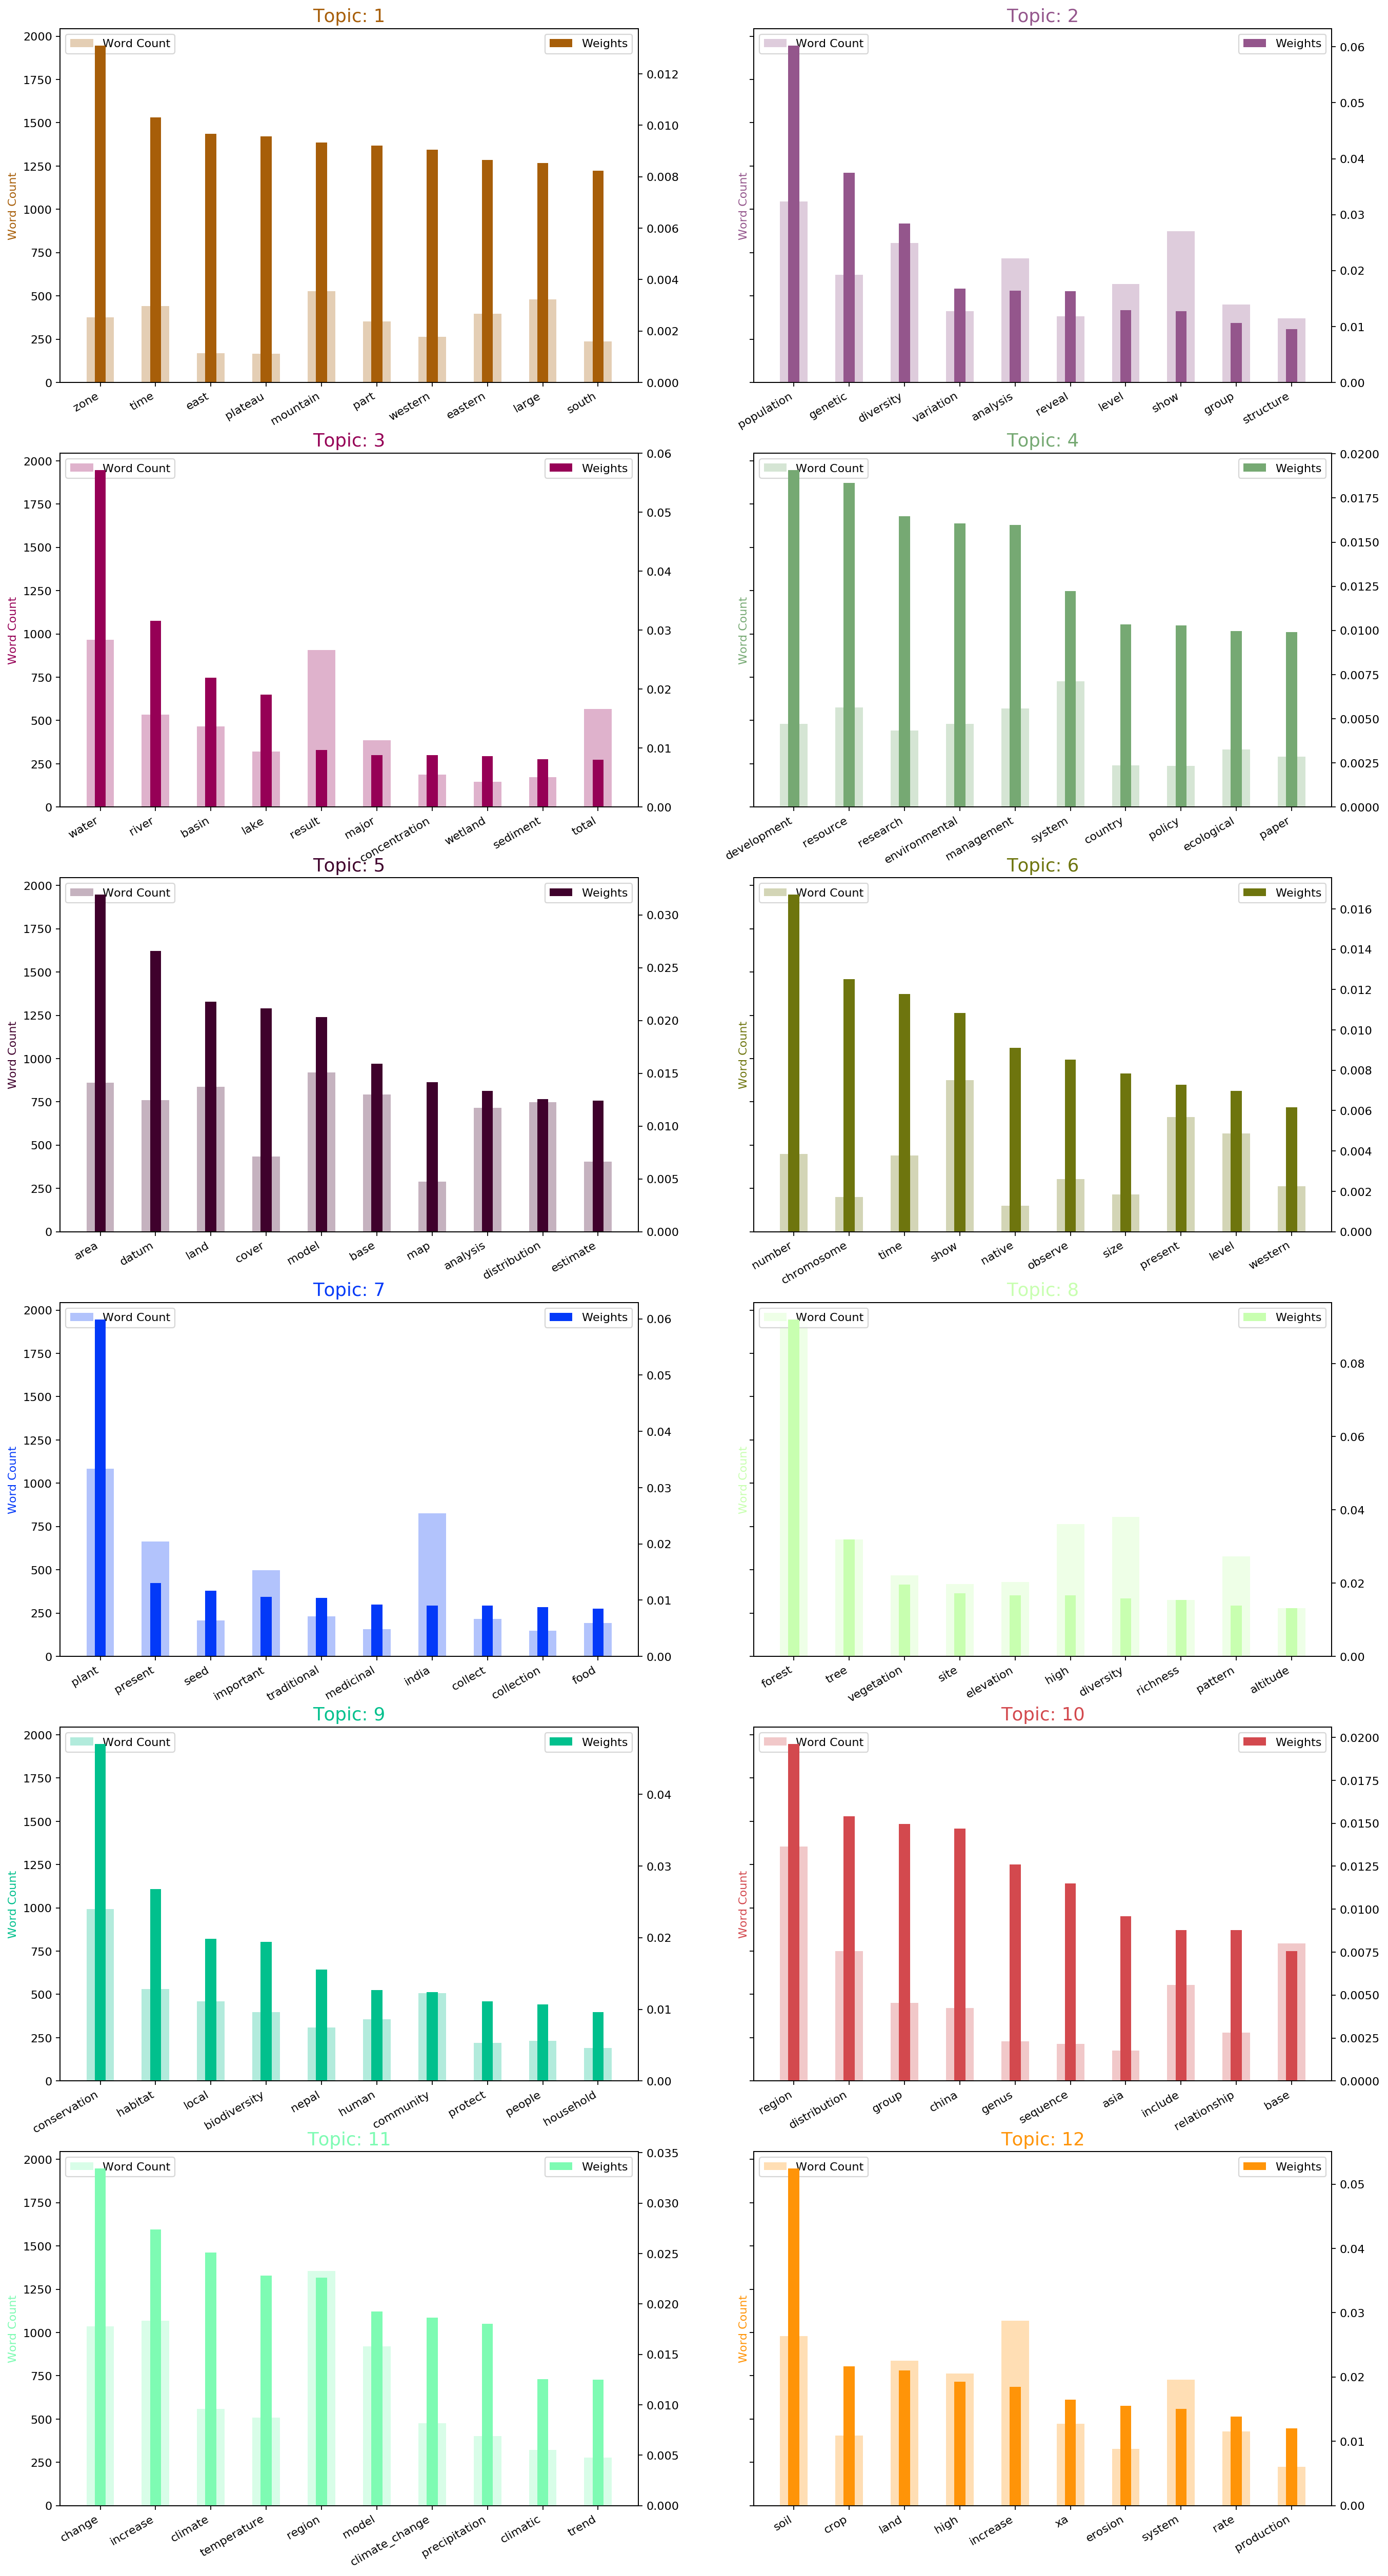

In [40]:
from collections import Counter
topics = optimal_model.show_topics(num_topics = -1, formatted=False)
data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(20, 40), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
plt.savefig(session_folder_name + '/EasternHimalayasTopics12.pdf')
plt.show()